<a href="https://colab.research.google.com/github/Elliot-Bl/GarminTCXtoCSV/blob/main/Parse_gpx_and_tcx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
fname = '/content/drive/MyDrive/Running/Holiday half (phone armband).gpx'
watch_fname = '/content/drive/MyDrive/Running/holiday half.tcx'
age = 39

In [ ]:
import xml.etree.ElementTree as ET
mytree = ET.parse(fname)
myroot = mytree.getroot()
print('Just a test:\n', myroot)

Just a test:
 <Element '{http://www.topografix.com/GPX/1/1}gpx' at 0x79b469597c40>


In [ ]:
"""Some functions for parsing a TCX file (specifically, a TCX file
downloaded from Strava, which was generated based on data recorded by a
Garmin vívoactive 3) and creating a Pandas DataFrame with the data.
"""

from datetime import datetime, timedelta
from typing import Dict, Optional, Any, Union, Tuple

import lxml.etree
import pandas as pd
import dateutil.parser as dp


NAMESPACES = {
    'schemaLocation': 'http://www.topografix.com/GPX/1/1',
    'gpxtpx': 'http://www.garmin.com/xmlschemas/TrackPointExtension/v1',
    'ns': 'http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2',
    'ns2': 'http://www.garmin.com/xmlschemas/UserProfile/v2',
    'ns3': 'http://www.garmin.com/xmlschemas/ActivityExtension/v2',
    'ns4': 'http://www.garmin.com/xmlschemas/ProfileExtension/v1',
    'ns5': 'http://www.garmin.com/xmlschemas/ActivityGoals/v1'
}

# The names of the columns we will use in our points DataFrame
POINTS_COLUMN_NAMES = ['latitude', 'longitude', 'elevation', 'time', 'heart_rate']

def get_gpx_point_data(point: lxml.etree._Element) -> Optional[Dict[str, Union[float, int, str, datetime]]]:
    """Extract some data from an XML element representing a track point
    and return it as a dict.
    """

    data: Dict[str, Union[float, int, str, datetime]] = {}

    data['latitude'] = float(point.attrib['lat'])
    data['longitude'] = float(point.attrib['lon'])

    time_str = point.find('schemaLocation:time', NAMESPACES).text
    data['time'] = dp.parse(time_str)

    elevation_elem = point.find('schemaLocation:ele', NAMESPACES)
    if elevation_elem is not None:
        data['elevation'] = float(elevation_elem.text)

    hr_elem = point.find('schemaLocation:extensions', NAMESPACES).find('gpxtpx:TrackPointExtension', NAMESPACES)
    if hr_elem is not None:
        data['heart_rate'] = int(hr_elem.find('gpxtpx:hr', NAMESPACES).text)

    return data


def get_gpx_dataframes(fname: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Takes the path to a GPX file (as a string) and returns two Pandas
    DataFrames: one containing data about the laps, and one containing
    data about the individual points.
    """

    tree = lxml.etree.parse(fname)
    root = tree.getroot()
    activity = root.find('schemaLocation:trk', NAMESPACES)  # Assuming we know there is only one Activity in the GPX file
                                                          # (or we are only interested in the first one)
    points_data = []
    for seg in activity.findall('schemaLocation:trkseg', NAMESPACES):
        for point in seg.findall('schemaLocation:trkpt', NAMESPACES):
            points_data.append(get_gpx_point_data(point))

    # Create DataFrames from the data we have collected. If any information is missing from a particular lap or track
    # point, it will show up as a null value or "NaN" in the DataFrame.

    points_df = pd.DataFrame(points_data, columns=POINTS_COLUMN_NAMES)

    return points_df


In [ ]:
gpx_points_df = get_gpx_dataframes(fname)
print('Dataframe:')

Dataframe:


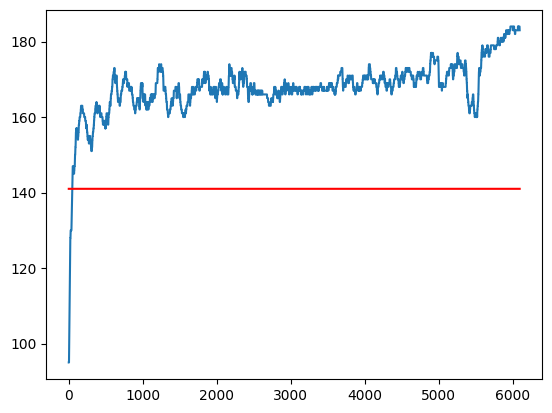

In [ ]:
# from re import A
import matplotlib.pyplot as plt
import numpy as np

plt.plot(gpx_points_df['heart_rate'])
aerobic_line = np.ones_like(gpx_points_df['heart_rate'])*(180-age)
plt.plot(aerobic_line, color='red')

In [ ]:
#now I will load the watch file

# The names of the columns we will use in our points DataFrame
POINTS_COLUMN_NAMES = ['latitude', 'longitude', 'elevation', 'time', 'heart_rate', 'cadence', 'speed', 'lap']

# The names of the columns we will use in our laps DataFrame
LAPS_COLUMN_NAMES = ['number', 'start_time', 'distance', 'total_time', 'max_speed', 'max_hr', 'avg_hr']

def get_tcx_lap_data(lap: lxml.etree._Element) -> Dict[str, Union[float, datetime, timedelta, int]]:
    """Extract some data from an XML element representing a lap and
    return it as a dict.
    """

    data: Dict[str, Union[float, datetime, timedelta, int]] = {}

    # Note that because each element's attributes and text are returned as strings, we need to convert those strings
    # to the appropriate datatype (datetime, float, int, etc).

    start_time_str = lap.attrib['StartTime']
    data['start_time'] = dp.parse(start_time_str)

    distance_elem = lap.find('ns:DistanceMeters', NAMESPACES)
    if distance_elem is not None:
        data['distance'] = float(distance_elem.text)

    total_time_elem = lap.find('ns:TotalTimeSeconds', NAMESPACES)
    if total_time_elem is not None:
        data['total_time'] = timedelta(seconds=float(total_time_elem.text))

    max_speed_elem = lap.find('ns:MaximumSpeed', NAMESPACES)
    if max_speed_elem is not None:
        data['max_speed'] = float(max_speed_elem.text)

    max_hr_elem = lap.find('ns:MaximumHeartRateBpm', NAMESPACES)
    if max_hr_elem is not None:
        data['max_hr'] = float(max_hr_elem.find('ns:Value', NAMESPACES).text)

    avg_hr_elem = lap.find('ns:AverageHeartRateBpm', NAMESPACES)
    if avg_hr_elem is not None:
        data['avg_hr'] = float(avg_hr_elem.find('ns:Value', NAMESPACES).text)

    return data

def get_tcx_point_data(point: lxml.etree._Element) -> Optional[Dict[str, Union[float, int, str, datetime]]]:
    """Extract some data from an XML element representing a track point
    and return it as a dict.
    """

    data: Dict[str, Union[float, int, str, datetime]] = {}

    position = point.find('ns:Position', NAMESPACES)
    if position is not None:
        data['latitude'] = float(position.find('ns:LatitudeDegrees', NAMESPACES).text)
        data['longitude'] = float(position.find('ns:LongitudeDegrees', NAMESPACES).text)

    time_str = point.find('ns:Time', NAMESPACES).text
    data['time'] = dp.parse(time_str)

    elevation_elem = point.find('ns:AltitudeMeters', NAMESPACES)
    if elevation_elem is not None:
        data['elevation'] = float(elevation_elem.text)

    hr_elem = point.find('ns:HeartRateBpm', NAMESPACES)
    if hr_elem is not None:
        data['heart_rate'] = int(hr_elem.find('ns:Value', NAMESPACES).text)

    cad_elem = point.find('ns3:RunCadence', NAMESPACES)
    if cad_elem is not None:
        data['cadence'] = int(cad_elem.text)

    # The ".//" here basically tells lxml to search recursively down the tree for the relevant tag, rather than just the
    # immediate child elements of speed_elem. See https://lxml.de/tutorial.html#elementpath
    speed_elem = point.find('.//ns3:Speed', NAMESPACES)
    if speed_elem is not None:
        data['speed'] = float(speed_elem.text)

    return data


def get_tcx_dataframes(fname: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Takes the path to a TCX file (as a string) and returns two Pandas
    DataFrames: one containing data about the laps, and one containing
    data about the individual points.
    """

    tree = lxml.etree.parse(fname)
    root = tree.getroot()
    print(root)
    print(root.find('ns:Activities', NAMESPACES))
    activity = root.find('ns:Activities', NAMESPACES)[0]  # Assuming we know there is only one Activity in the TCX file
                                                          # (or we are only interested in the first one)
    points_data = []
    laps_data = []
    lap_no = 1
    for lap in activity.findall('ns:Lap', NAMESPACES):
        # Get data about the lap itself
        single_lap_data = get_tcx_lap_data(lap)
        single_lap_data['number'] = lap_no
        laps_data.append(single_lap_data)

        # Get data about the track points in the lap
        track = lap.find('ns:Track', NAMESPACES)
        for point in track.findall('ns:Trackpoint', NAMESPACES):
            single_point_data = get_tcx_point_data(point)
            if single_point_data:
                single_point_data['lap'] = lap_no
                points_data.append(single_point_data)
        lap_no += 1

    # Create DataFrames from the data we have collected. If any information is missing from a particular lap or track
    # point, it will show up as a null value or "NaN" in the DataFrame.

    laps_df = pd.DataFrame(laps_data, columns=LAPS_COLUMN_NAMES)
    laps_df.set_index('number', inplace=True)
    points_df = pd.DataFrame(points_data, columns=POINTS_COLUMN_NAMES)

    return laps_df, points_df

In [ ]:
tcx_laps_df, tcx_points_df = get_tcx_dataframes(watch_fname)

<Element {http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}TrainingCenterDatabase at 0x79b43468ff00>
<Element {http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Activities at 0x79b434477700>


In [ ]:
tcx_points_df.columns

Index(['latitude', 'longitude', 'elevation', 'time', 'heart_rate', 'cadence',
       'speed', 'lap'],
      dtype='object')

In [ ]:
def merge_tcx_gpx(tcx_points_df: pd.DataFrame, gpx_points_df: pd.DataFrame) -> pd.DataFrame:
    # Merge the two dataframes on time
    tcx_points_df.rename(columns={'heart_rate':'watch_hr'}, inplace=True)
    gpx_points_df.rename(columns={'heart_rate':'arm_hr'}, inplace=True)

    merged_points_df = pd.merge(tcx_points_df, gpx_points_df[['time', 'arm_hr']], on='time', how='inner')

    # hr_diff is the difference between watch and armband measurements. Not to be confused with time_diff
    merged_points_df['hr_diff'] = merged_points_df['watch_hr'] - merged_points_df['arm_hr']

    # Calculate time_diff which is time since the race started
    merged_points_df['time_diff'] = merged_points_df['time'] - merged_points_df['time'].min()

    # Convert time differences to hh:mm:ss format
    merged_points_df['time_diff'] = pd.to_timedelta(merged_points_df['time_diff']).dt.total_seconds()
    # this changes the type to a str so I found it better to leave it as a dt and then ignore the d/m/y
    merged_points_df['time_diff'] = pd.to_datetime(merged_points_df['time_diff'], unit='s')#.dt.strftime('%H:%M:%S')
    return merged_points_df

In [ ]:
merged_points_df = merge_tcx_gpx(tcx_points_df, gpx_points_df)

In [ ]:
def plot_hr_difference(merged_points_df, title=None):
    # Plot both HR lines
    plt.plot(merged_points_df['time_diff'], merged_points_df['watch_hr'])
    plt.plot(merged_points_df['time_diff'], merged_points_df['arm_hr'])

    aerobic_line = np.ones_like(merged_points_df['arm_hr'])*(180-age)
    plt.plot(merged_points_df['time_diff'], aerobic_line, color='red')
    plt.legend(['Watch HR', 'Armband HR', 'Aerobic Threshold'])
    plt.xlabel('Time')
    plt.xticks(rotation = 45)
    plt.ylabel('Heart Rate')
    plt.ylim([120, 190])
    plt.title(title)
    plt.show()

    plt.hist(merged_points_df['hr_diff'], bins=40)
    plt.title('Watch HR - Armband HR')
    plt.show()

    # Calculate the RMSE. RMSE punishes more for big errors
    rmse = np.sqrt(((merged_points_df['arm_hr'] - merged_points_df['watch_hr']) ** 2).mean())

    print("RMSE:", rmse)

    #average error is a little more intuitive for me
    avg_error = abs(merged_points_df['hr_diff']).mean()
    print("Average Error:", avg_error)

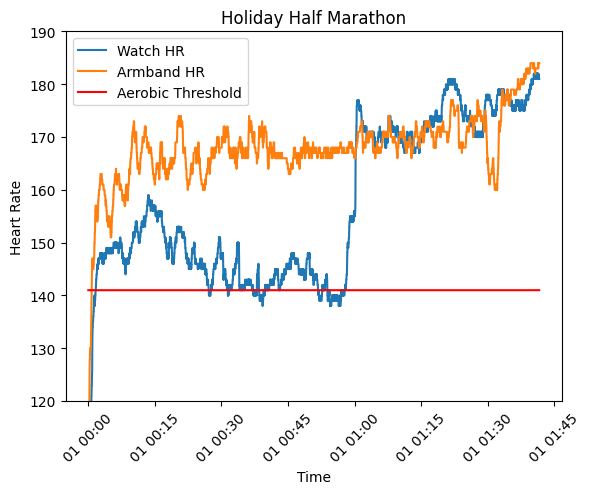

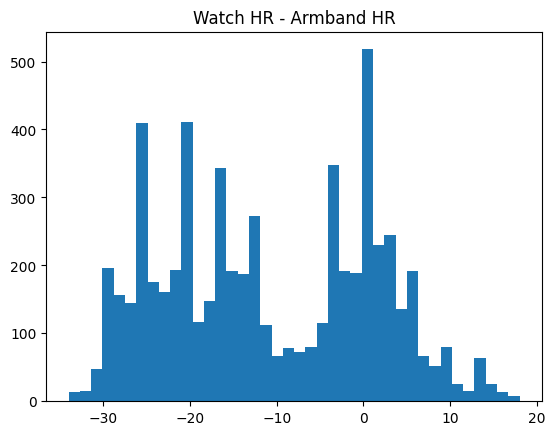

RMSE: 16.16224888700659
Average Error: 13.048180924287118


In [ ]:
plot_hr_difference(merged_points_df, 'Holiday Half Marathon')

In [ ]:
# position_error = np.abs(gpx_points_df['longitude']-tcx_points_df['longitude'])+ np.abs(gpx_points_df['latitude']-tcx_points_df['latitude'])
# plt.scatter(gpx_points_df['longitude'], gpx_points_df['latitude'], c=[position_error[:len(gpx_points_df)]], cmap='viridis')
# plt.colorbar(label='Position Error (degrees)')

<Element {http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}TrainingCenterDatabase at 0x79b43428be00>
<Element {http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Activities at 0x79b43e333a40>


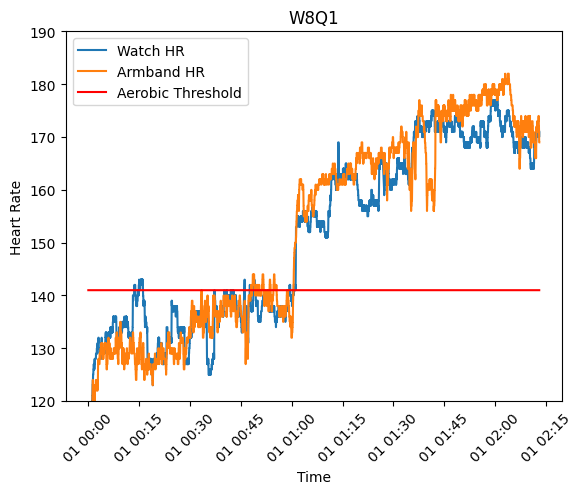

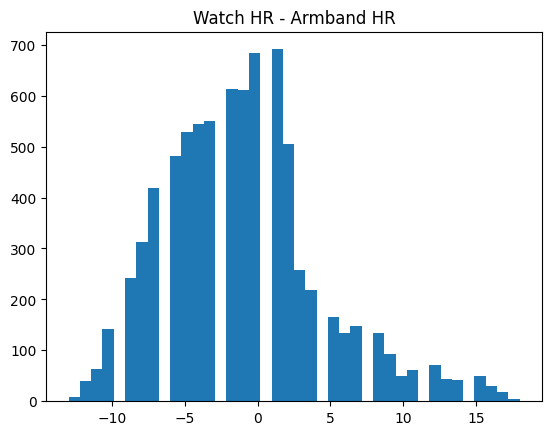

RMSE: 5.495843859082025
Average Error: 4.296831782750817


In [ ]:
# Do it again for another run
garmin_file = '/content/drive/MyDrive/Running/w8q1.tcx'
armband_file = '/content/drive/MyDrive/Running/w8q1.gpx'
garmin_laps_df, garmin_points_df = get_tcx_dataframes(garmin_file)
armband_points_df = get_gpx_dataframes(armband_file)
merged_points_df = merge_tcx_gpx(garmin_points_df, armband_points_df)
plot_hr_difference(merged_points_df, 'W8Q1')

<Element {http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}TrainingCenterDatabase at 0x79b4342e7880>
<Element {http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Activities at 0x79b4321a2f80>


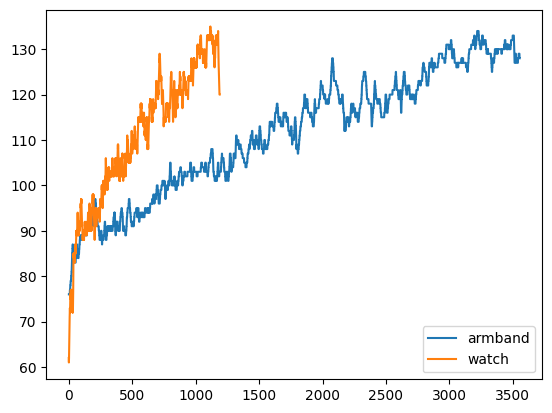

In [ ]:
hr_on_armband = pd.read_csv('/content/drive/MyDrive/Running/HR on armband.csv')
hr_on_armband.rename(columns={'timestamp':'time'}, inplace=True)
hr_on_armband['time'] = pd.to_datetime(hr_on_armband['time'], format='%m/%d/%Y, %I:%M:%S %p').dt.tz_localize('tzlocal()')
plt.plot(hr_on_armband['heart rate'])
hr_on_watch_laps, hr_on_watch = get_tcx_dataframes('/content/drive/MyDrive/Running/cycle watch.tcx')
hr_on_watch['time'] = hr_on_watch['time']-timedelta(hours=8)
plt.plot(hr_on_watch['heart_rate'])
plt.legend(['armband','watch'])
# print(hr_on_watch)

In [ ]:
# print(type(hr_on_watch['time'][1]), type(hr_on_armband['time'][1]))

# timestamp = pd.to_datetime(hr_on_armband['time'], format='%m/%d/%Y, %I:%M:%S %p').to_datetime64()


# print("Timestamp:", timestamp)
# print(hr_on_watch['time'])
# print(hr_on_armband['time'])
print(len(merged_points_df['arm_hr']))

7954


In [ ]:
# formatting and merging both HRs into one df
hr_on_watch.rename(columns={'heart_rate':'watch_hr'}, inplace=True)
hr_on_armband.rename(columns={'heart rate':'arm_hr', 'timestamp':'time'}, inplace=True)

merged_hr_df = pd.merge(hr_on_watch, hr_on_armband[['time', 'arm_hr']], on='time', how='outer')

merged_hr_df['hr_diff'] = merged_hr_df['watch_hr'] - merged_hr_df['arm_hr']

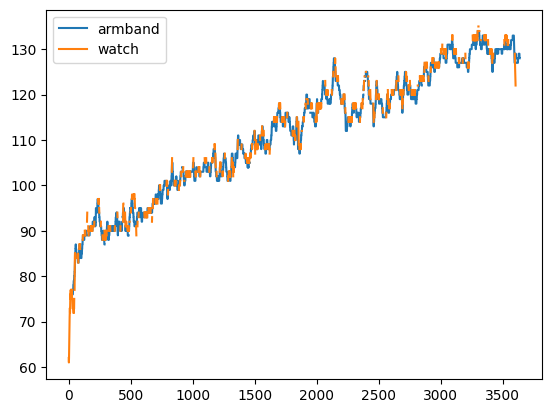

In [ ]:
plt.plot(merged_hr_df['arm_hr'])
plt.plot(merged_hr_df['watch_hr'])
plt.legend(['armband','watch'])

RMSE: 1.3709551678625953
Average Error: 0.9225473321858864


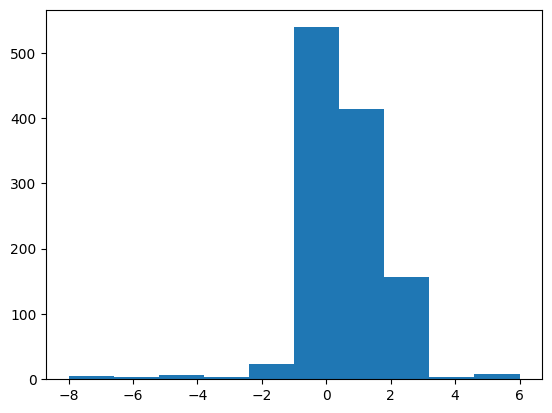

In [ ]:
plt.hist(merged_hr_df['hr_diff'], bins=10)

# Calculate the RMSE. RMSE punishes more for big errors
rmse = np.sqrt(((merged_hr_df['arm_hr'] - merged_hr_df['watch_hr']) ** 2).mean())

print("RMSE:", rmse)

#average error is a little more intuitive for me
avg_error = abs(merged_hr_df['hr_diff']).mean()
print("Average Error:", avg_error)

<Element {http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}TrainingCenterDatabase at 0x79b43427ba00>
<Element {http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Activities at 0x79b43427abc0>


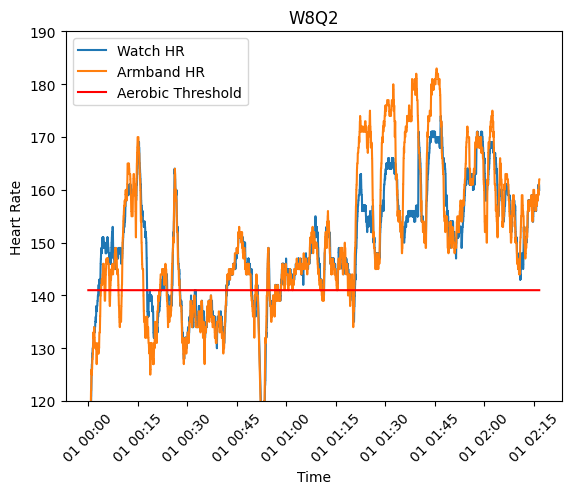

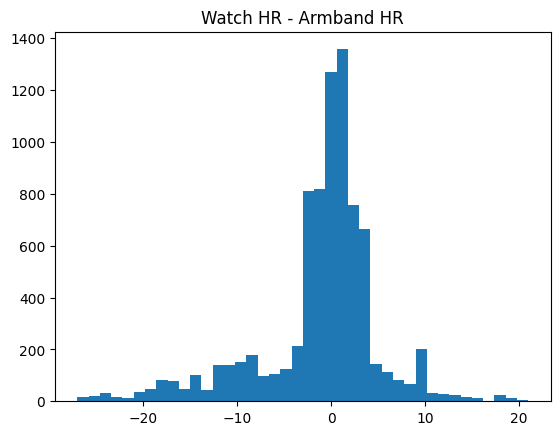

RMSE: 6.517389086308974
Average Error: 4.082615119428712


In [ ]:
# Do it again for another run
garmin_file = '/content/drive/MyDrive/Running/w8q2.tcx'
armband_file = '/content/drive/MyDrive/Running/w8q2.gpx'
garmin_laps_df, garmin_points_df = get_tcx_dataframes(garmin_file)
armband_points_df = get_gpx_dataframes(armband_file)
merged_points_df = merge_tcx_gpx(garmin_points_df, armband_points_df)
plot_hr_difference(merged_points_df, 'W8Q2')
# My hypothesis is that the watch does poorly when it's not tight. I like to wear it a bit loose

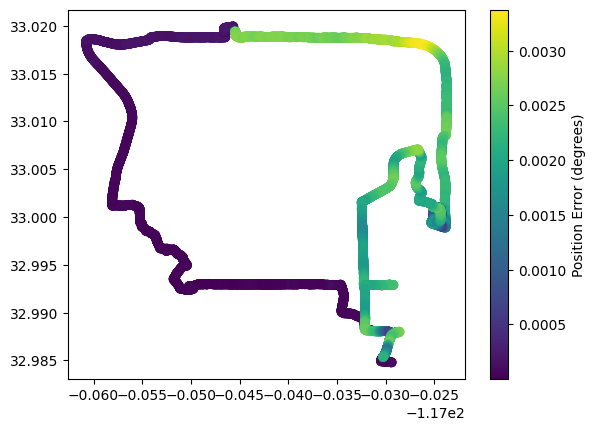

In [ ]:
position_error = np.abs(armband_points_df['longitude']-garmin_points_df['longitude'])+ np.abs(armband_points_df['latitude']-garmin_points_df['latitude'])
plt.scatter(armband_points_df['longitude'], armband_points_df['latitude'], c=[position_error], cmap='viridis')
plt.colorbar(label='Position Error (degrees)')

<Element {http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}TrainingCenterDatabase at 0x79b43068aa40>
<Element {http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Activities at 0x79b43068aa80>


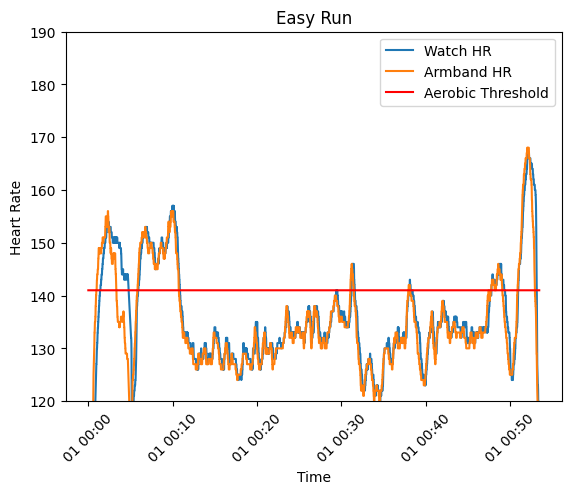

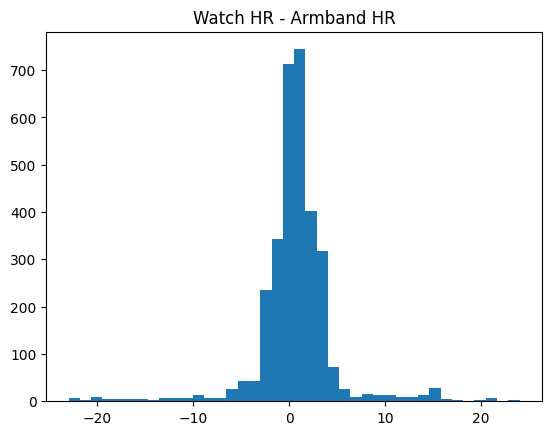

RMSE: 4.2120131307886455
Average Error: 2.346829880728186


In [ ]:
# Do it again for another run
garmin_file = '/content/drive/MyDrive/Running/run 12-26.tcx'
armband_file = '/content/drive/MyDrive/Running/run 12-26.gpx'
garmin_laps_df, garmin_points_df = get_tcx_dataframes(garmin_file)
armband_points_df = get_gpx_dataframes(armband_file)
merged_points_df = merge_tcx_gpx(garmin_points_df, armband_points_df)
plot_hr_difference(merged_points_df, 'Easy Run')

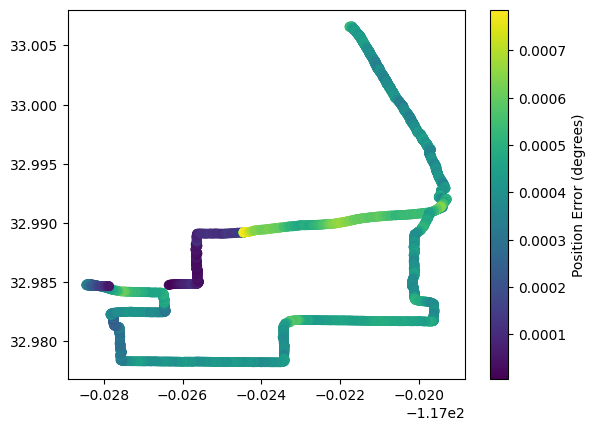

In [ ]:
position_error = np.abs(armband_points_df['longitude']-garmin_points_df['longitude'])+ np.abs(armband_points_df['latitude']-garmin_points_df['latitude'])
plt.scatter(armband_points_df['longitude'], armband_points_df['latitude'], c=[position_error], cmap='viridis')
plt.colorbar(label='Position Error (degrees)')

<Element {http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}TrainingCenterDatabase at 0x79b432128780>
<Element {http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Activities at 0x79b430716140>


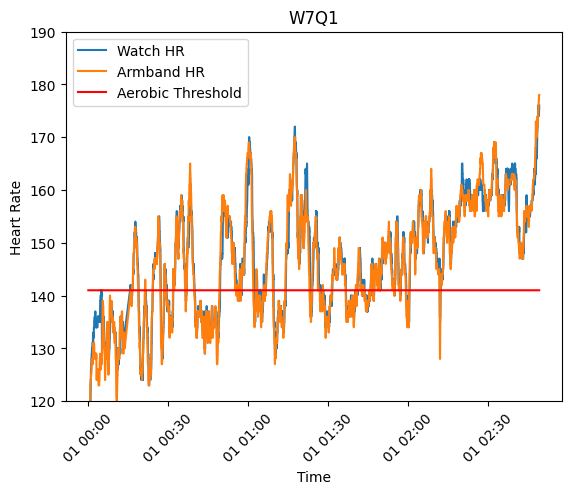

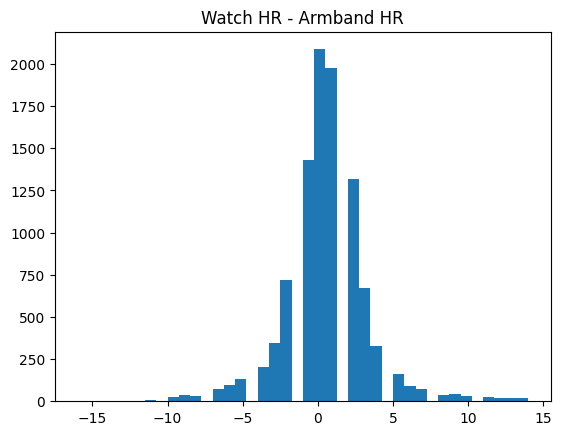

RMSE: 2.9088288881863407
Average Error: 1.9504733432984553


In [ ]:
# Do it again for another run
garmin_file = '/content/drive/MyDrive/Running/w7q1.tcx'
armband_file = '/content/drive/MyDrive/Running/w7q1.gpx'
garmin_laps_df, garmin_points_df = get_tcx_dataframes(garmin_file)
armband_points_df = get_gpx_dataframes(armband_file)
merged_points_df = merge_tcx_gpx(garmin_points_df, armband_points_df)
plot_hr_difference(merged_points_df, 'W7Q1')

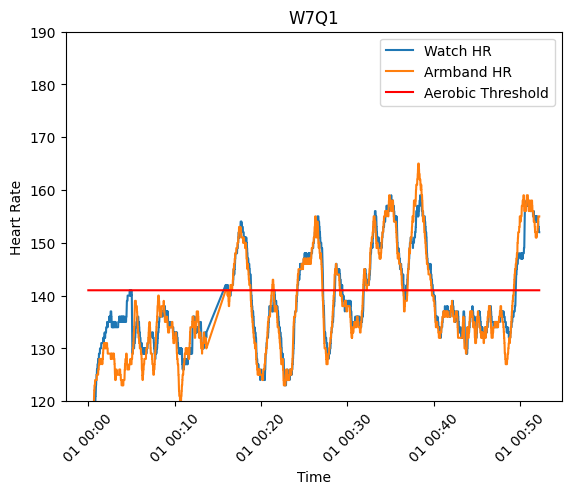

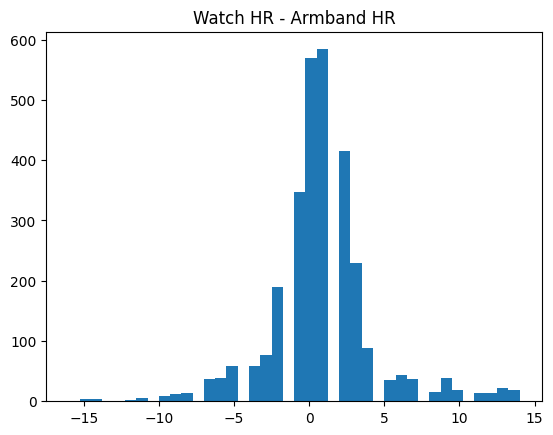

RMSE: 3.6467794010606123
Average Error: 2.388333333333333


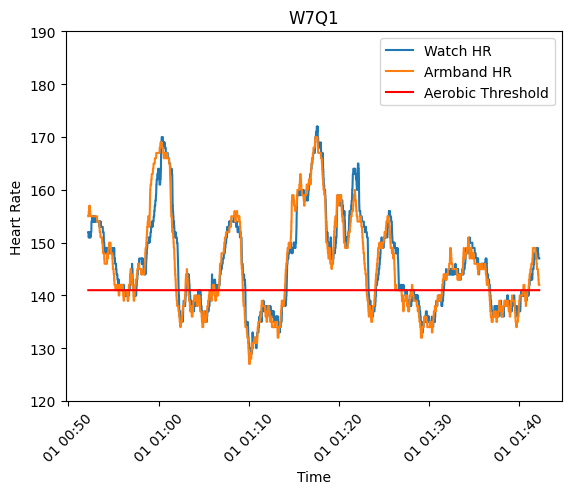

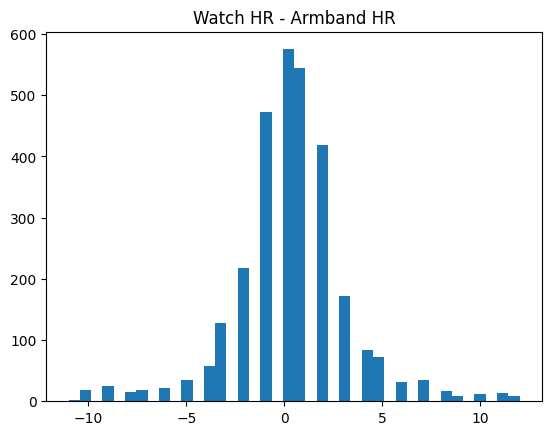

RMSE: 2.9792616534973897
Average Error: 2.034666666666667


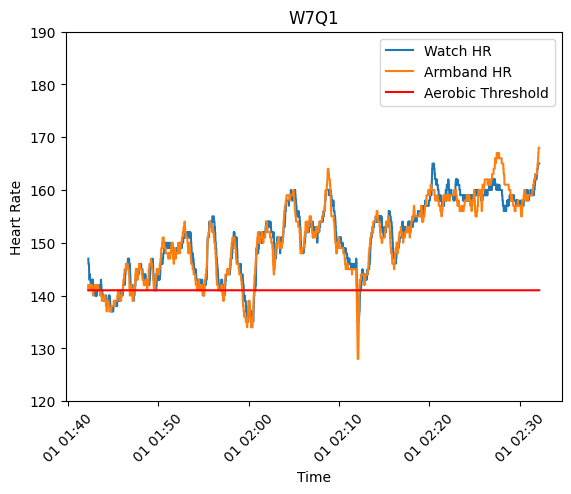

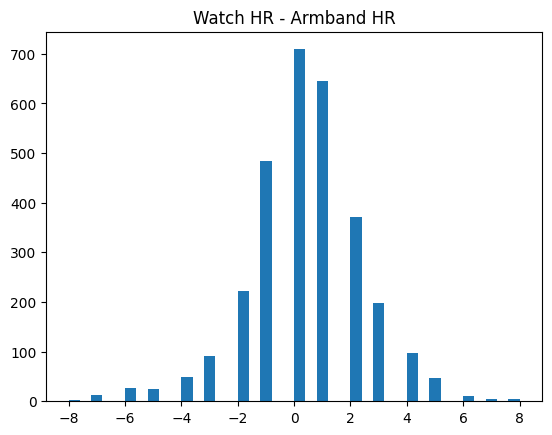

RMSE: 2.067042976492426
Average Error: 1.5066666666666666


In [ ]:
plot_hr_difference(merged_points_df[:3000], 'W7Q1')
plot_hr_difference(merged_points_df[3000:6000], 'W7Q1')
plot_hr_difference(merged_points_df[6000:9000], 'W7Q1')

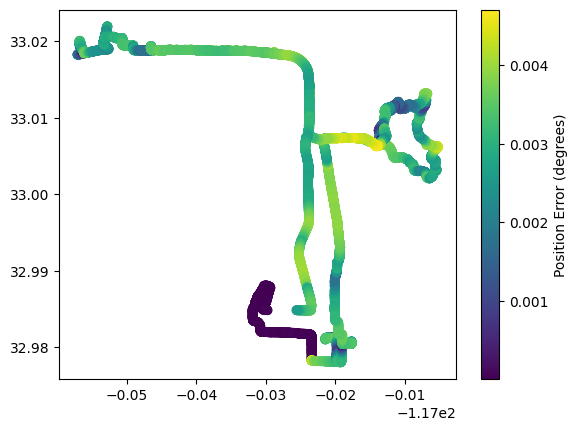

In [ ]:
# print(armband_points_df.columns)
# print(garmin_points_df.columns)

position_error = np.abs(armband_points_df['longitude']-garmin_points_df['longitude'])+ np.abs(armband_points_df['latitude']-garmin_points_df['latitude'])
plt.scatter(armband_points_df['longitude'], armband_points_df['latitude'], c=[position_error], cmap='viridis')
plt.colorbar(label='Position Error (degrees)')
# plt.scatter(garmin_points_df['longitude'], garmin_points_df['latitude'])
plt.show()

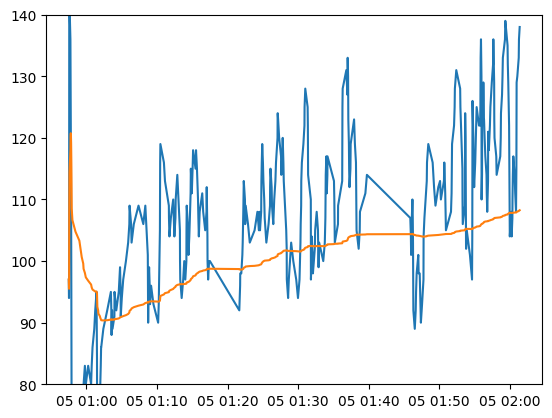

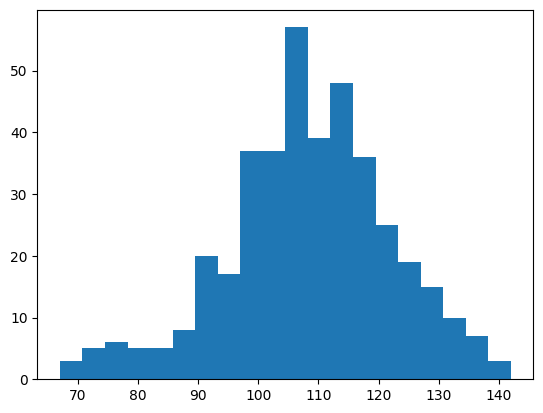

In [ ]:
armband_file = '/content/drive/MyDrive/Running/sauna.gpx'
armband_points_df = get_gpx_dataframes(armband_file)
armband_points_df['cum_avg'] = armband_points_df['heart_rate'].expanding().mean()
plt.plot(armband_points_df['time'], armband_points_df['heart_rate'])
plt.plot(armband_points_df['time'], armband_points_df['cum_avg'])
plt.ylim([80,140])
plt.show()
plt.hist(armband_points_df['heart_rate'], bins=20)
plt.show()


In [ ]:
400/60

6.666666666666667